# 뉴럴 스타일 트랜스퍼

*Note: 이 코드는 <케라스 창시자에게 배우는 딥러닝> 8.3절의 [주피터 노트북](https://github.com/rickiepark/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb)에서 가져왔습니다.*

In [1]:
from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = './data/neural_style_transfer/tubingen.jpg'
# 스타일 이미지 경로
style_reference_image_path = './data/neural_style_transfer/starry-night.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 600
img_width = int(width * img_height / height)

print(img_width, img_height)

Using TensorFlow backend.
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/haesun/github/GDL_co

800 600


/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/haesun/github/GDL_code/en

In [2]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

W0913 01:11:09.044561 140391382955840 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 01:11:09.046793 140391382955840 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 01:11:09.048158 140391382955840 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 01:11:09.068213 140391382955840 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Pleas

In [4]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [5]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [6]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [7]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1
style_weight = 100
content_weight = 20

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

W0913 01:11:10.066848 140391382955840 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [8]:
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

W0913 01:11:10.249059 140391382955840 deprecation.py:323] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
from scipy.optimize import fmin_l_bfgs_b

result_file = './data/neural_style_transfer/style_transfer_result.png'
iterations = 1000

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    if i % 100 == 0:
        print('.', end=' ')
        print('현재 손실 값:', min_val)

# 생성된 현재 이미지를 저장합니다
img = x.copy().reshape((img_height, img_width, 3))
img = deprocess_image(img)

save_img(result_file, img)

. 현재 손실 값: 89980764000.0
. 현재 손실 값: 9619082000.0
. 현재 손실 값: 9428106000.0
. 현재 손실 값: 9420333000.0
. 현재 손실 값: 9420333000.0
. 현재 손실 값: 9420333000.0
. 현재 손실 값: 9420333000.0
. 현재 손실 값: 9420333000.0
. 현재 손실 값: 9420333000.0
. 현재 손실 값: 9420333000.0


In [10]:
from matplotlib import pyplot as plt

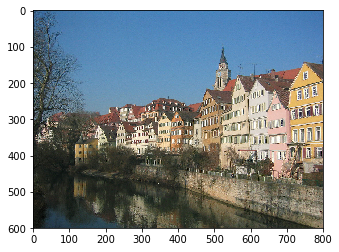

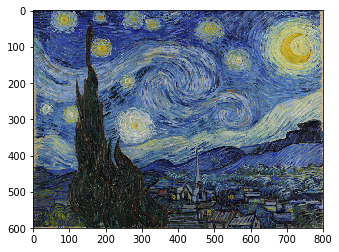

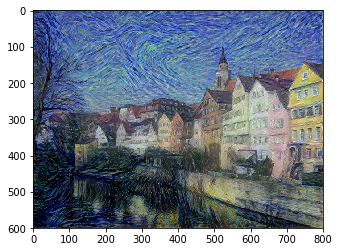

In [11]:
# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()

결과 이미지

![style_transfer_result](./data/neural_style_transfer/style_transfer_result.png)